In [38]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


Read the data in pandas dataframe

In [27]:
data = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')

data = data.astype({
    'time': 'int64',
    'class': 'int64',
    'label': 'int64',
    'channel1': 'float64',
    'channel2': 'float64',
    'channel3': 'float64',
    'channel4': 'float64',
    'channel5': 'float64',
    'channel6': 'float64',
    'channel7': 'float64',
    'channel8': 'float64'
})

#_dir = "ft_sdft_data"
#os.makedirs(output_dir, exist_ok=True)

In [3]:
# Find the indices where the 'time' column resets to 0
reset_indices = data.index[data['time'] == 1].tolist()

# Split the data into separate DataFrames based on the reset indices
split_data = []

for i in range(len(reset_indices) - 1):
    split_data.append(data.iloc[reset_indices[i]:reset_indices[i + 1]])

# Append the last segment of data
split_data.append(data.iloc[reset_indices[-1]:])

# Display the number of segments
print(f"Number of segments: {len(split_data)}")

Number of segments: 58


In [4]:
# Count the number of segments for each label
label_counts = {}

for segment in split_data:
    if not segment.empty:
        label = segment['label'].iloc[0]
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Display the counts for each label
print(label_counts)

{1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 2, 17: 1, 18: 2, 19: 1, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 1, 28: 1, 30: 1, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2}


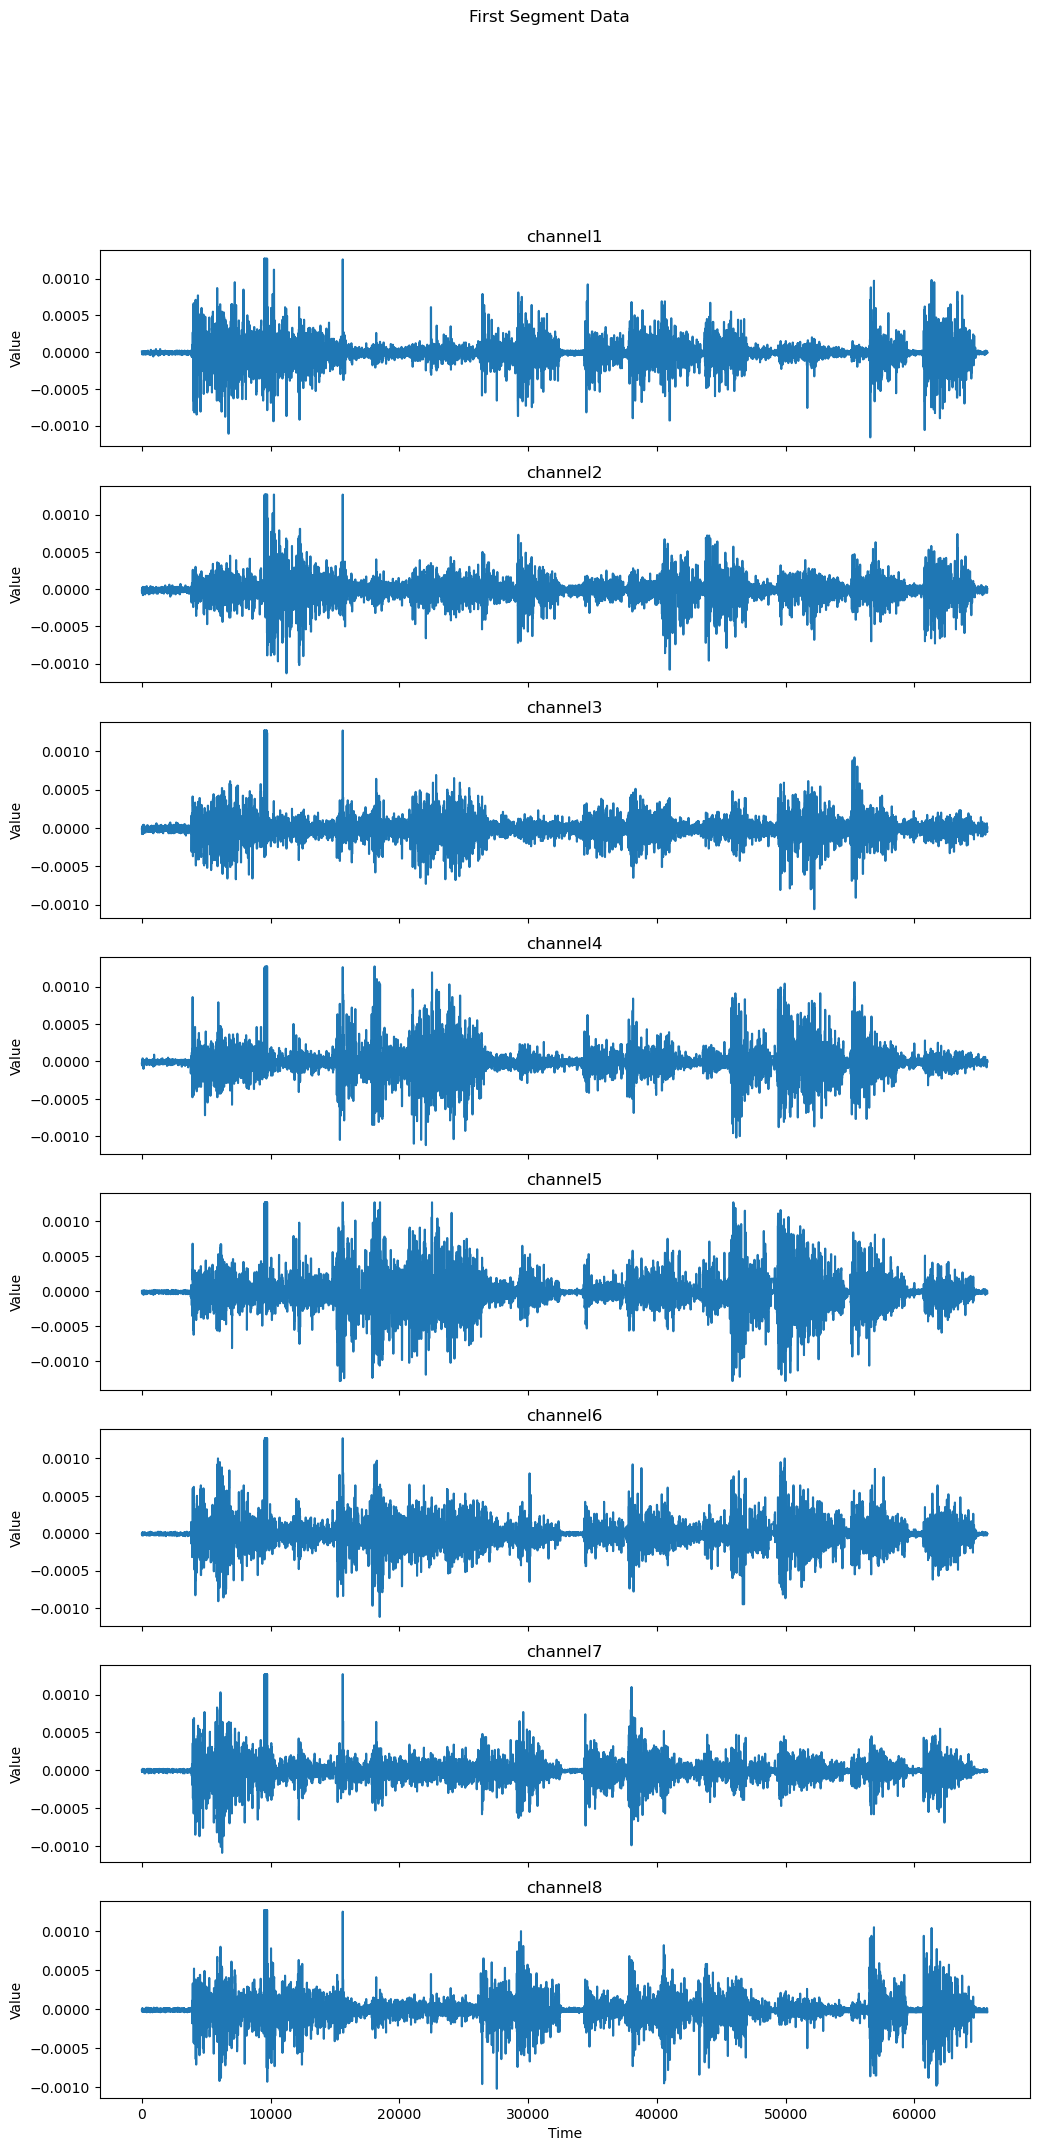

In [5]:
# Plot the first segment in split_data
first_segment = split_data[0]

# Plotting the data
fig, axs = plt.subplots(8, 1, figsize=(12, 24), sharex=True)
channels = first_segment.columns[1:9]  # Exclude 'time' column

for i, column in enumerate(channels):
    axs[i].plot(first_segment['time'], first_segment[column])
    axs[i].set_title(column)
    axs[i].set_ylabel('Value')

plt.xlabel('Time')
plt.suptitle('First Segment Data')
plt.show()

In [28]:
import pandas as pd
import numpy as np
from scipy.fft import fft
from scipy.signal import welch

# Define the channels you're interested in
channels = ['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8']

# Track label and segment counts
label_segment_count = {}


# Function to calculate Zero Crossing (ZC)
def calculate_zc(signal):
    zero_crossings = np.where(np.diff(np.signbit(signal)))[0]
    return len(zero_crossings)

# Function to calculate Slope Sign Changes (SSC)
def calculate_ssc(signal):
    ssc = np.sum(np.diff(np.sign(np.diff(signal))) != 0)
    return ssc

# Function to calculate Waveform Length (WL)
def calculate_wl(signal):
    wl = np.sum(np.abs(np.diff(signal)))
    return wl

# Fourier Transform (FT)
def calculate_ft(signal):
    ft = fft(signal)
    return np.abs(ft)

# Short-time Fourier Transform (SDFT)
def calculate_sdft(signal, window_size):
    step_size = window_size // 2  # 50% overlap
    sdft_features = []
    for i in range(0, len(signal) - window_size, step_size):
        windowed_signal = signal[i:i+window_size]
        sdft = fft(windowed_signal)
        sdft_features.append(np.abs(sdft))
    return np.array(sdft_features)

# Power Spectral Density (PSD)
def calculate_psd(signal, fs=1000):
    freqs, psd = welch(signal, fs)
    return freqs, psd

# RMS and Mean Absolute Value (MAV)
def calculate_rms(signal):
    return np.sqrt(np.mean(np.square(signal)))

def calculate_mav(signal):
    return np.mean(np.abs(signal))




In [ ]:
# Sampling frequency
fs = 1000

# Feature extraction loop
features_by_segment = []
channels = ['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8']

for segment in split_data:
    if segment.empty:
        continue
    
    label = segment['label'].iloc[0]
    gesture_classes = segment['class'].unique()  # Get all unique gestures in the segment
    
    # Determine whether it's the first or second segment for this label
    if label not in label_segment_count:
        label_segment_count[label] = 0
    label_segment_count[label] += 1
    segment_suffix = 'a' if label_segment_count[label] == 1 else 'b'
    
    # Iterate over gestures within the segment
    for gesture in gesture_classes:
        gesture_data = segment[segment['class'] == gesture]
        
        for channel in channels:
            signal = gesture_data[channel].values
            
            # Create a dictionary to hold the features for this segment, channel, and gesture
            channel_features = {}
            
            # Feature calculations
            ft_features = calculate_ft(signal)
            channel_features['ft_mean'] = np.mean(ft_features)
            channel_features['ft_max'] = np.max(ft_features)
            
            ## Saving FT and SDFT data
            # ft_df = pd.DataFrame({'Frequency_Bin': np.arange(len(ft_features)), 'Magnitude': ft_features})
            # ft_filename = f"{output_dir}/ft_label_{label}{segment_suffix}_gesture_{gesture}_channel_{int(channel.replace('channel', ''))}.csv"
            # ft_df.to_csv(ft_filename, index=False)
            
            
            window_size = 256  # Example window size
            sdft_features = calculate_sdft(signal, window_size)
            channel_features['sdft_mean'] = np.mean(sdft_features)
            channel_features['sdft_max'] = np.max(sdft_features)
            
            # Store SDFT data
            sdft_features = calculate_sdft(signal, window_size)
            # sdft_df = pd.DataFrame(sdft_features)
            # sdft_filename = f"{output_dir}/sdft_label_{label}{segment_suffix}_gesture_{gesture}_channel_{int(channel.replace('channel', ''))}.csv"
            # sdft_df.to_csv(sdft_filename, index=False)
            
            freqs, psd = calculate_psd(signal, fs)
            channel_features['psd_mean'] = np.mean(psd)
            channel_features['psd_max'] = np.max(psd)
            
            channel_features['zero_cross'] = calculate_zc(signal)
            channel_features['slope_sign_c'] = calculate_ssc(signal)
            channel_features['wavef_l'] = calculate_wl(signal)
            channel_features['rms'] = calculate_rms(signal)
            channel_features['mav'] = calculate_mav(signal)
            
            # Additional stats
            channel_features['mean'] = np.mean(signal)
            channel_features['min'] = np.min(signal)
            channel_features['max'] = np.max(signal)
            channel_features['variance'] = np.var(signal)
            
            # Add the identifiers for Channel, Label&Segment, and Gesture
            channel_features['Channel'] = int(channel.replace('channel', ''))
            channel_features['Label&Segment'] = f"{label}{segment_suffix}"
            channel_features['Gesture'] = gesture
            
            # Append the features for this channel and gesture
            features_by_segment.append(channel_features)

# Convert the extracted features to a DataFrame
features_df = pd.DataFrame(features_by_segment)

# Save to CSV
features_df.to_csv('emg_extracted_features_by_class.csv', index=False)

# Display first few rows of the final DataFrame
print(features_df.head())


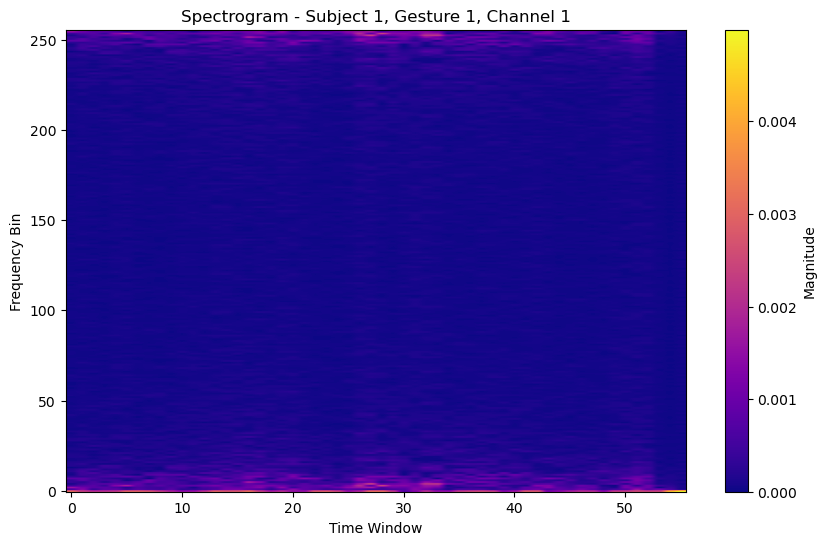

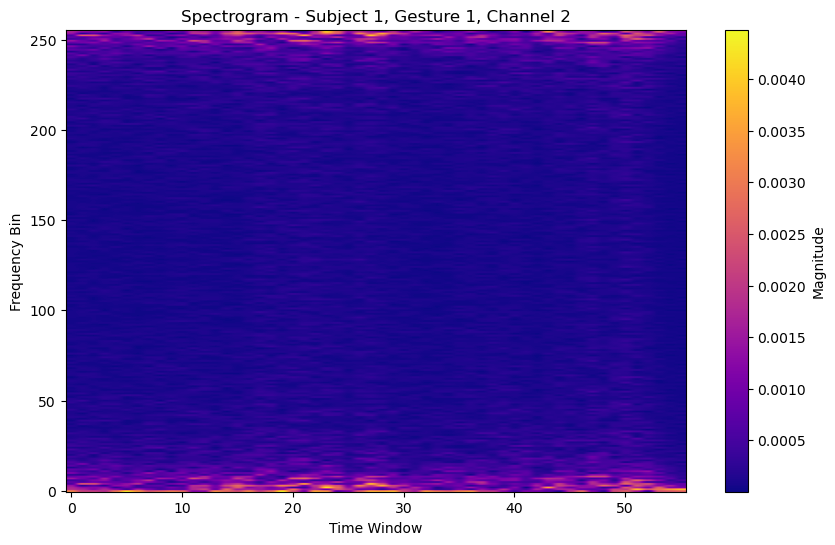

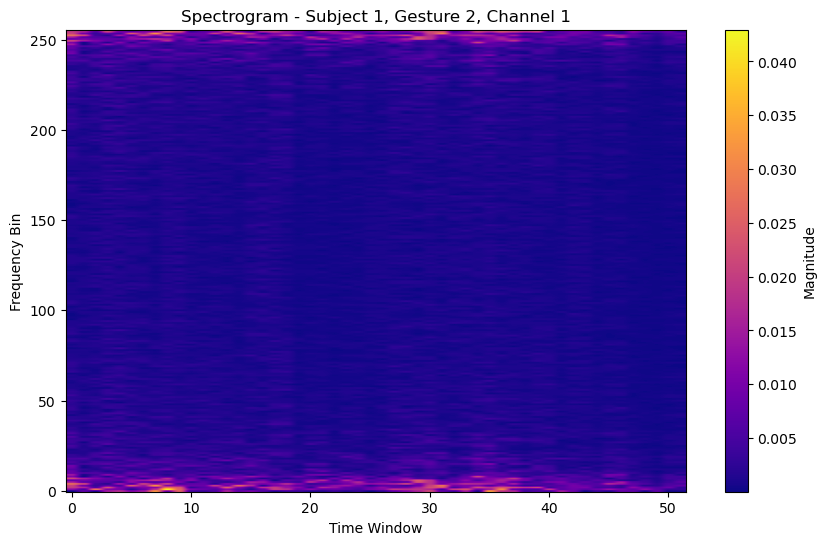

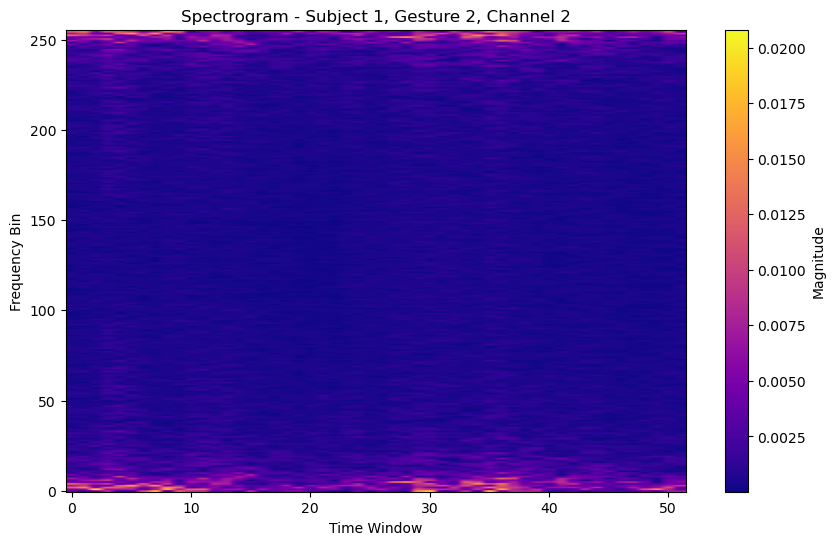

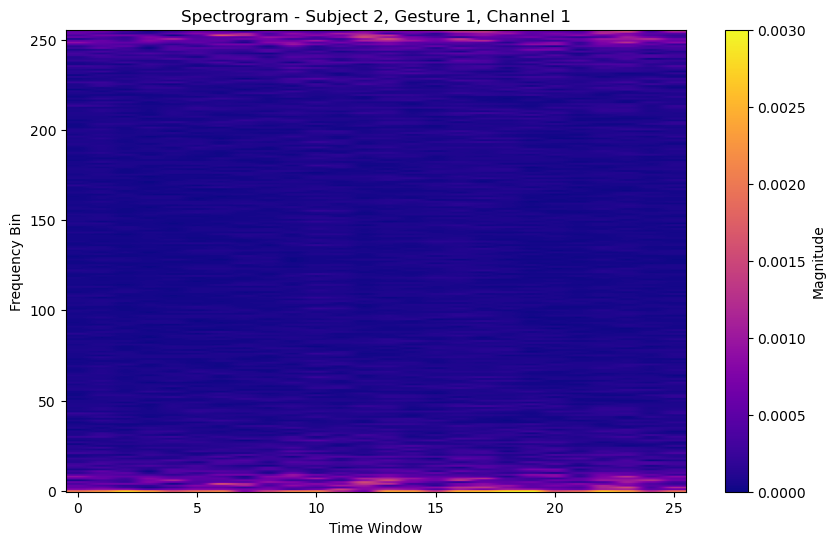

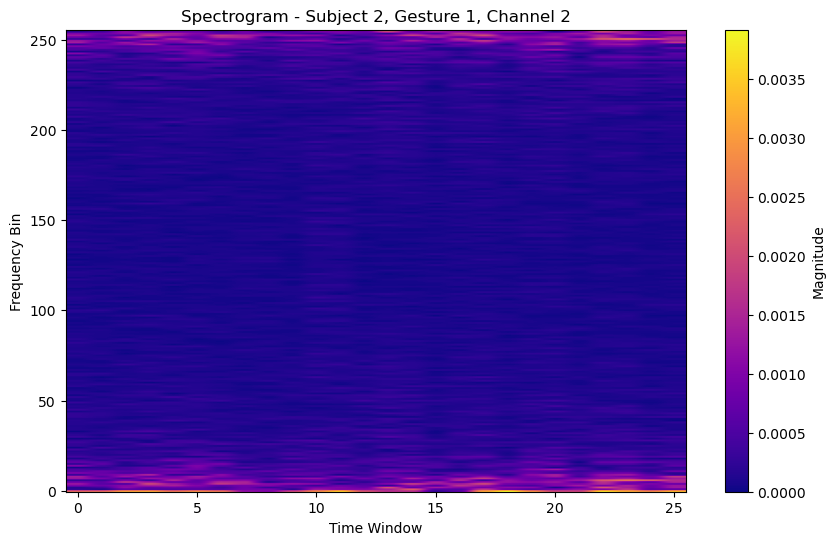

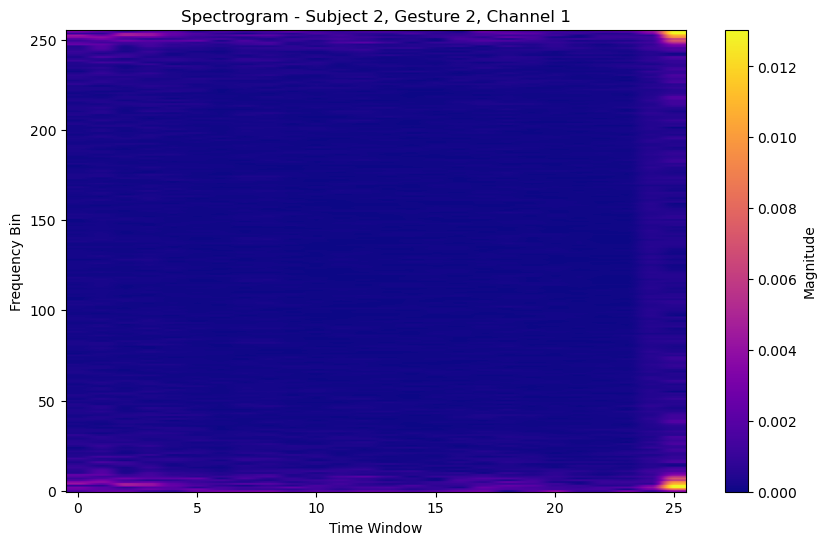

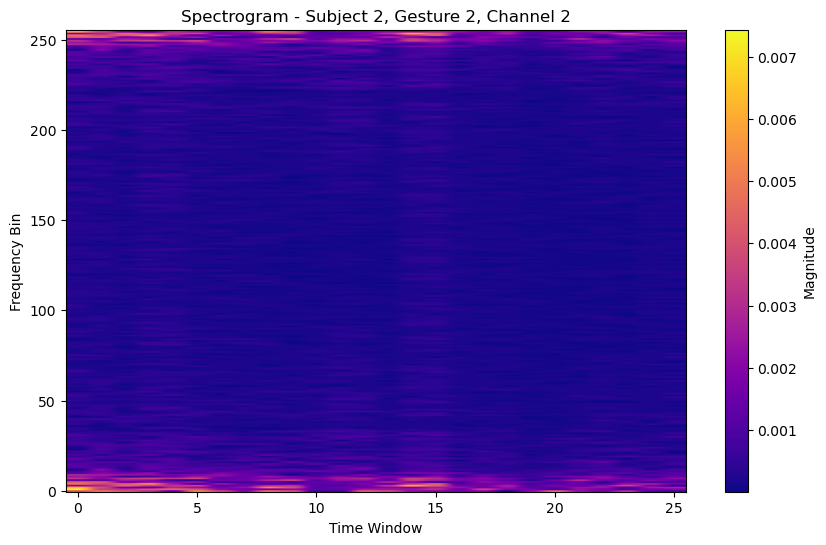

In [34]:
# Define directory where the SDFT csvs are saved
freq_data_dir = "ft_sdft_data"  # Change this to your actual directory

# Function to load SDFT data from a CSV file
def load_sdft_csv(label, segment, gesture, channel, freq_data_dir):
    # Construct the filename based on label, segment, gesture, and channel
    filename = f"sdft_label_{label}{segment}_gesture_{gesture}_channel_{channel}.csv"
    filepath = os.path.join(freq_data_dir, filename)
    
    if os.path.exists(filepath):
        # Load the CSV as a DataFrame
        sdft_data = pd.read_csv(filepath)
        return sdft_data
    else:
        print(f"File {filename} does not exist.")
        return None

# Function to plot the SDFT spectrogram from a DataFrame
def plot_spectrogram_from_sdft(sdft_data, title):
    plt.figure(figsize=(10, 6))
    
    # Convert the DataFrame into a NumPy array
    sdft_matrix = sdft_data.to_numpy()
    
    # Plot the matrix as a heatmap (magnitude of SDFT over time)
    plt.imshow(sdft_matrix.T, aspect='auto', origin='lower', cmap='plasma')
    plt.title(title)
    plt.ylabel('Frequency Bin')
    plt.xlabel('Time Window')
    plt.colorbar(label='Magnitude')
    plt.show()

# Define the label (subject), gesture, and channel you want to plot
labels = [1,2]  # Example: subject 1
segments = ['a']  # Example: first segment (a)
gestures = [1,2]  # Example: gesture 1
channels = [1,2]  # Example: channel 1

for label in labels:
    for segment in segment:
        for gesture in gestures:
            for channel in channels:
                # Load the SDFT data for the specified label, segment, gesture, and channel
                sdft_data = load_sdft_csv(label, segment, gesture, channel, freq_data_dir)
                # Plot the SDFT spectrogram if data was successfully loaded
                if sdft_data is not None:
                    plot_spectrogram_from_sdft(sdft_data, f"Spectrogram - Subject {label}, Gesture {gesture}, Channel {channel}")



In [39]:

features_df = pd.read_csv('emg_extracted_features_by_class.csv')

# Step 2: Prepare feature matrix (X) and labels (y)
# Here we use the following features: ZC, SSC, WL, RMS, MAV, etc.

# Extract features from the DataFrame (ignore columns like Channel, Gesture, Label&Segment)
selected_features = ['zero_cross', 'slope_sign_c', 'wavef_l', 'rms', 'mav']

X = features_df[selected_features] 

# Extract the labels (gesture class)
y = features_df['Gesture']  # The 'Gesture' column contains the labels (0 to 7)

# Step 3: Normalize the feature matrix (X)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Train a logistic regression model for classification
model = LogisticRegression(multi_class='ovr', solver='lbfgs', max_iter=500)
model.fit(X_train, y_train)

# Step 6: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 7: Evaluate the model
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Print classification report (Precision, Recall, F1-Score)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optionally, you can save the model for future use
# from joblib import dump
# dump(model, 'emg_logistic_regression_model.joblib')


Accuracy: 45.73%
Confusion Matrix:
[[92  0  0  0  0  0  0  0]
 [ 0 88  0  4  0  1  0  0]
 [ 0  2 37 16 17 21  0  0]
 [ 0 15 17 24 10 27  0  0]
 [ 0 13 11 14 27 28  0  0]
 [ 0 14 17 21  9 32  0  0]
 [ 0 13 23 24 10 23  0  0]
 [ 0  1  2  1  0  2  0  0]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        92
           1       0.60      0.95      0.74        93
           2       0.35      0.40      0.37        93
           3       0.23      0.26      0.24        93
           4       0.37      0.29      0.33        93
           5       0.24      0.34      0.28        93
           6       0.00      0.00      0.00        93
           7       0.00      0.00      0.00         6

    accuracy                           0.46       656
   macro avg       0.35      0.40      0.37       656
weighted avg       0.39      0.46      0.42       656



c:\Users\dsliu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dsliu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\dsliu\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
